[Table of Contents](http://nbviewer.ipython.org/github/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/table_of_contents.ipynb)

# Adaptive Filtering

In [1]:
#format the book
%matplotlib inline
%load_ext autoreload
%autoreload 2  
from __future__ import division, print_function
import sys
sys.path.insert(0,'./code')
from book_format import load_style, set_figsize, figsize
load_style()

## Introduction

So far we have considered the problem of tracking objects that are well behaved in relation to our process model. For example, we can use a constant velocity model track an object moving in a straight line. So long as the object moves in a straight line at a reasonably constant speed, or varies it's track and/or velocity very slowly this filter will perform very well. Suppose instead that we are trying to track a maneuvering target, by which I mean an object with control inputs, such as a car along a road, an aircraft in flight, and so on. In these situations the filters perform quite poorly. Alternatively, consider a situation such as tracking a sailboat in the ocean. Even if we model the control inputs we have no way to model the wind or the ocean currents. 

A first order approach to this problem is to make the process noise $\mathbf{Q}$ larger to account for the unpredictability of the system dynamics. While this can *work* in the sense of providing a non-diverging filter, the result is typically far from optimal. The larger $\mathbf{Q}$ results in the filter giving more emphasis to the noise in the measurements. We will see an example of this shortly.

So in this chapter we will discuss the concept of an *adaptive filter*. This means about what it sounds like. The filter will *adapt* itself when it detects dynamics that the process model cannot account for. I will start with an example of the problem, and then discuss and implement various adaptive filters.

## Maneuvering Targets

So let's begin by writing a simulation of a maneuvering target. We are not interested in modeling anything with high fidelity, nor do we really care about 3 dimensions, so I will implement a simple 2D model that you can provide steering inputs into. You can provide a new speed and/or direction, and it will modify its state to match.

In [2]:
from math import sin, cos, radians

def angle_between(x,y):
  return min(y-x, y-x+360, y-x-360, key=abs)

class ManeuveringTarget(object): 
    def __init__(self, x0, y0, v0, heading):
        self.x = x0
        self.y = y0
        self.vel = v0
        self.hdg = heading
        
        self.cmd_vel = v0
        self.cmd_hdg = heading
        self.vel_step = 0
        self.hdg_step = 0
        self.vel_delta = 0
        self.hdg_delta = 0
        
        
    def update(self):
        vx = self.vel * cos(radians(90-self.hdg))
        vy = self.vel * sin(radians(90-self.hdg))
        self.x += vx
        self.y += vy
        
        if self.hdg_step > 0:
            self.hdg_step -= 1
            self.hdg += self.hdg_delta

        if self.vel_step > 0:
            self.vel_step -= 1
            self.vel += self.vel_delta
        return (self.x, self.y)
        

    def set_commanded_heading(self, hdg_degrees, steps):
        self.cmd_hdg = hdg_degrees
        self.hdg_delta = angle_between(self.cmd_hdg, self.hdg) / steps
        if abs(self.hdg_delta) > 0:
            self.hdg_step = steps
        else:
            self.hdg_step = 0
            
            
    def set_commanded_speed(self, speed, steps):
        self.cmd_vel = speed
        self.vel_delta = (self.cmd_vel - self.vel) / steps
        if abs(self.vel_delta) > 0:
            self.vel_step = steps
        else:
            self.vel_step = 0    

Now let's implement a simulated sensor with noise.

In [3]:
from numpy.random import randn

class NoisySensor(object):
    def __init__(self, noise_factor=1):
        self.noise_factor = noise_factor

    def sense(self, pos):
        return (pos[0] + randn()*self.noise_factor, 
                pos[1] + randn()*self.noise_factor)

Now let's generate a track and plot it to test that everything is working and to see what we will be trying to track. I'll put the data generation in a function so we can create paths of different lengths (why will be clear soon).

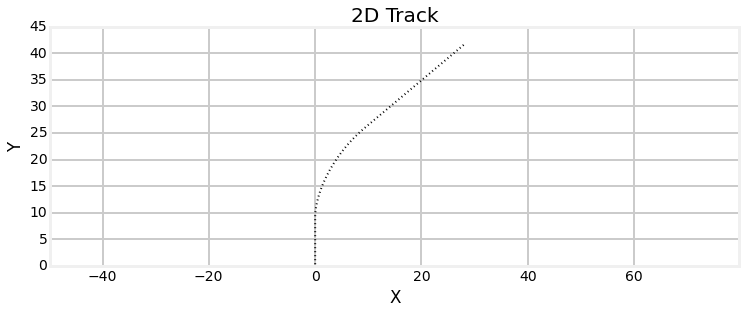

In [4]:
from numpy import array
import matplotlib.pyplot as plt

import book_plots as bp

noise_factor = 2.

def generate_data(steady_count, noise_factor):
    t = ManeuveringTarget(x0=0, y0=0, v0=0.3, heading=0)
    xs = []
    ys = []

    for i in range(30):
        x, y = t.update()
        xs.append(x)
        ys.append(y)

    t.set_commanded_heading(310, 25)
    t.set_commanded_speed(1, 15)

    for i in range(steady_count):
        x, y = t.update()
        xs.append(x)
        ys.append(y)

    ns = NoisySensor(noise_factor=noise_factor)
    pos = array(list(zip(xs, ys)))
    zs = array([ns.sense(p) for p in pos])
    return pos, zs

pos, zs = generate_data(50, noise_factor)
bp.plot_track(*zip(*pos))
plt.axis('equal')
bp.set_labels(title='2D Track', x='X', y='Y')

And here is the track vs the simulated sensor readings.

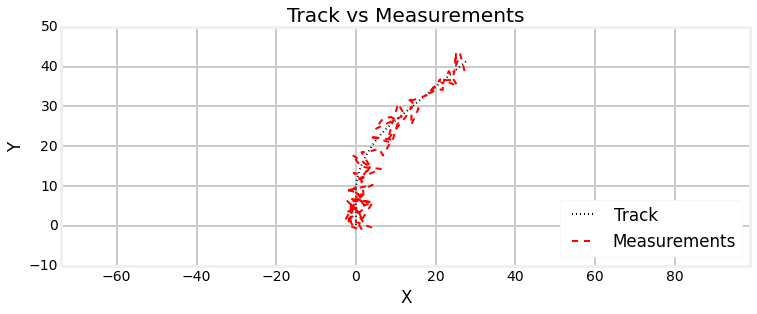

In [5]:
bp.plot_track(*zip(*pos))
bp.plot_measurements(*zip(*zs))
plt.axis('equal')
plt.legend(loc=4)
bp.set_labels(title='Track vs Measurements', x='X', y='Y')

This may appear to be an extreme amount of noise, but it will allow us to see the effect of various design choices more easily.

Now we can implement a Kalman filter to track this object. First let's implement a constant velocity filter. But let's make a simplification first. The *x* and *y* coordinates are independent, so we can track each independently. In the remainder of this chapter we will only track the *x* coordinate to keep the code and matrices as small as possible. 

In [6]:
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise

def make_cv_filter(dt):
    cvfilter = KalmanFilter(dim_x = 2, dim_z=1)
    cvfilter.x = array([0., 0.])
    cvfilter.P *= 3
    cvfilter.R *= noise_factor
    cvfilter.F = array([[1, dt],
                        [0,  1]], dtype=float)
    cvfilter.H = array([[1, 0]], dtype=float)
    cvfilter.Q = Q_discrete_white_noise(dim=2, dt=dt, var=0.02)
    
    return cvfilter

def initialize_filter(kf):
    """ helper function - we will be reinitialing the filter
    many times.
    """
    
    kf.x.fill(0)
    kf.P = np.eye(kf.x.shape[0]) * .1

To be clear about the dimension reduction, if we wanted to track both *x* and *y* we would have written

    cvfilter = KalmanFilter(dim_x = 4, dim_z=2)
    cvfilter.x = array([0., 0., 0., 0.])
    cvfilter.P *= 300
    cvfilter.R *= 1
    cvfilter.F = array([[1, dt, 0,  0],
                        [0,  1, 0,  0],
                        [0,  0, 1, dt],
                        [0,  0, 0,  1]], dtype=float)
    cvfilter.H = array([[1, 0, 0, 0],
                        [0, 0, 1, 0]], dtype=float)

    q = Q_discrete_white_noise(dim=2, dt=dt, var=0.020)
    cvfilter.Q[0:2, 0:2] = q
    cvfilter.Q[2:4, 2:4] = q

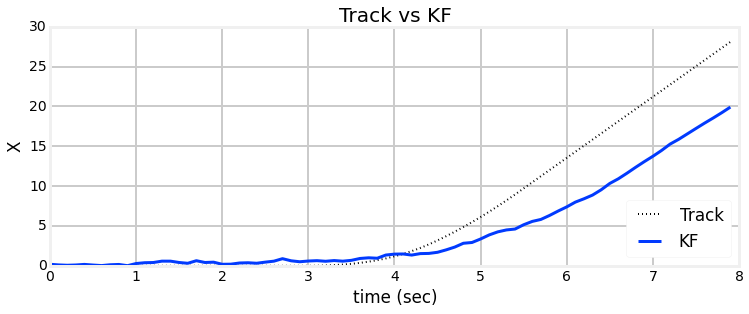

In [7]:
# extract the x coordinates
import numpy as np

dt = 0.1
# initialize filter
cvfilter= make_cv_filter(dt)
initialize_filter(cvfilter)

xs = pos[:, 0]
z_xs = zs[:, 0]
# plot the results
kxs, _, _, _ = cvfilter.batch_filter(z_xs)
t = np.arange(0, len(z_xs) * dt, dt)
bp.plot_track(t, xs)
bp.plot_filter(t, kxs[:, 0], label='KF')
bp.set_labels(title='Track vs KF', x='time (sec)', y='X');
plt.legend(loc=4)

We can see from the plot that the Kalman filter was unable to track the change in heading. Recall from the **g-h Filter** chapter that this is because the filter is not modeling acceleration, hence it will always lag the input. The filter will eventually catch up with the signal if the signal enters a steady state. Let's look at that.

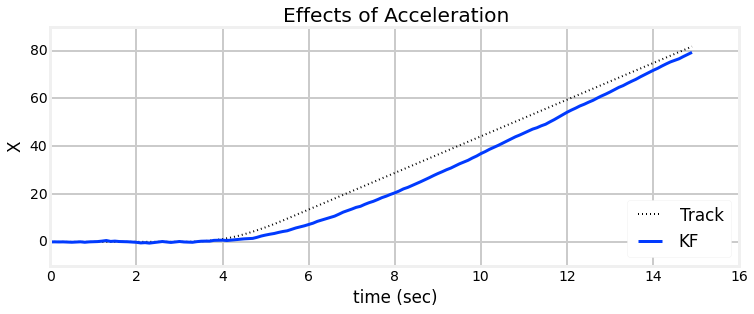

In [8]:
# reinitialize filter
initialize_filter(cvfilter)

pos2, zs2 = generate_data(120, noise_factor)
xs2 = pos2[:, 0]
z_xs2 = zs2[:, 0]
t = np.arange(0, len(xs2) * dt, dt)
# plot the results
kxs2, _, _, _ = cvfilter.batch_filter(z_xs2)

bp.plot_track(t, xs2)
bp.plot_filter(t, kxs2[:, 0], label='KF')
plt.legend(loc=4)
bp.set_labels(title='Effects of Acceleration', x='time (sec)', y='X')

The underlying problem is that our process model is correct for the steady state sections, but incorrect for when the object is maneuvering. We can try to account for this by increasing the size of Q, like so.

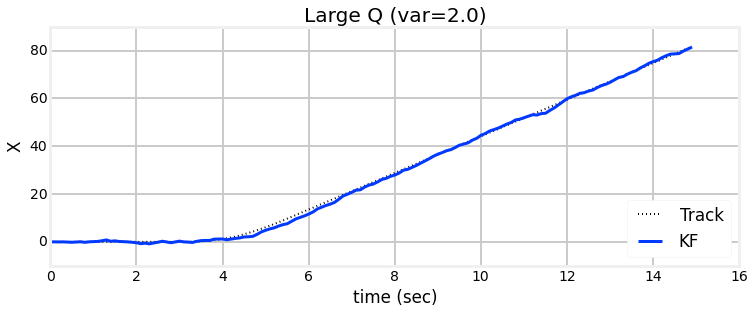

In [9]:
# reinitialize filter
initialize_filter(cvfilter)
cvfilter.Q = Q_discrete_white_noise(dim=2, dt=dt, var=2.0) # var was 0.02

# recompute track
kxs2, _, _, _ = cvfilter.batch_filter(z_xs2)

bp.plot_track(t, xs2)
bp.plot_filter(t, kxs2[:, 0], label='KF')
plt.legend(loc=4)
bp.set_labels(title='Large Q (var=2.0)', x='time (sec)', y='X')

We can see that the filter reacquired the track more quickly, but at the cost of a lot of noise in the output. Furthermore, many tracking situations could not tolerate the amount of lag shown between seconds 4 and 8. We could reduce it further at the cost of very noisy output, like so:

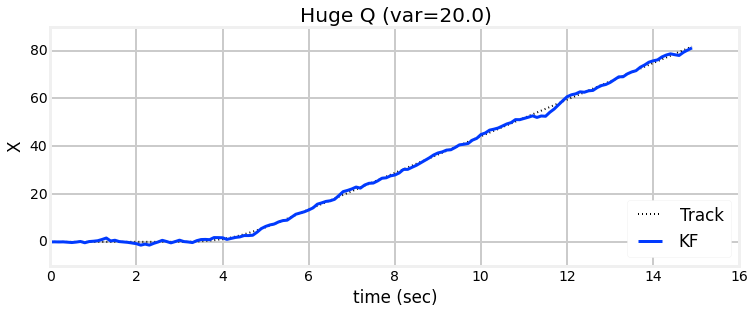

In [10]:
# reinitialize filter
initialize_filter(cvfilter)
cvfilter.Q = Q_discrete_white_noise(dim=2, dt=dt, var=20.0) # var was 0.02

# recompute track
cvfilter.x = array([0., 0.])
kxs2, _, _, _ = cvfilter.batch_filter(z_xs2)

bp.plot_track(t, xs2)
bp.plot_filter(t, kxs2[:, 0], label='KF')
plt.legend(loc=4)
bp.set_labels(title='Huge Q (var=20.0)', x='time (sec)', y='X')

Maneuvers imply acceleration, so let's implement a constant acceleration Kalman filter and see how it fairs with the same data.

In [11]:
def make_ca_filter(dt):
    cafilter = KalmanFilter(dim_x=3, dim_z=1)
    cafilter.x = array([0., 0., 0.])
    cafilter.P *= 3
    cafilter.R *= 1
    cafilter.Q = Q_discrete_white_noise(dim=3, dt=dt, var=0.02)
    cafilter.F = array([[1, dt, 0.5*dt*dt],
                        [0, 1,         dt], 
                        [0, 0,          1]], dtype=float)
    cafilter.H = array([[1, 0, 0]], dtype=float)
    return cafilter

def initialize_const_accel(f):
    f.x = array([0., 0., 0.])
    f.P = np.eye(3) * 3

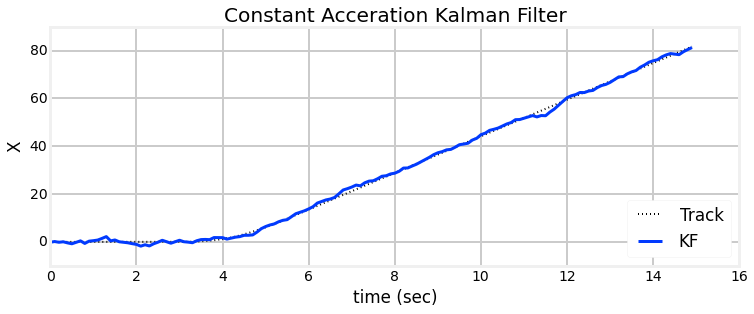

In [12]:
cafilter = make_ca_filter(dt)
initialize_const_accel(cafilter)

kxs2, _, _, _ = cafilter.batch_filter(z_xs2)
bp.plot_track(t, xs2)
bp.plot_filter(t, kxs2[:, 0], label='KF')
plt.legend(loc=4)
bp.set_labels(title='Constant Acceration Kalman Filter', x='time (sec)', y='X')

The constant acceleration model is able to track the maneuver with no lag, but at the cost of very noisy output during the steady state behavior. The noisy output is due to the filter being unable to distinguish between the beginning of an  maneuver and noise in the signal. Noise in the signal implies an acceleration, and so the acceleration term of the filter tracks it. 

It seems we cannot win. A constant velocity filter cannot react quickly when the target is accelerating, but a constant acceleration filter misinterprets noise during zero acceleration regimes as legitimate acceleration.

Yet there is an important insight here that will lead us to a solution. When the target is not maneuvering (the acceleration is zero) the constant velocity filter performs optimally. When the target is maneuvering the constant acceleration filter performs well, as does the constant velocity filter with an artificially large process noise $\mathbf{Q}$. If we make a filter that adapts itself to the behavior of the tracked object we could have the best of both worlds.

## Detecting a Maneuver

Before we discuss how to create an adaptive filter we have to ask *how do we detect a maneuver?* We cannot reasonably adapt a filter to respond to maneuvers if we do not know when a maneuver is happening.

We have been defining *maneuver* as the time when the tracked object is accelerating, but in general we can say that the object is maneuvering with respect to the Kalman filter if its behavior is different than the process model being used by the filter. 

What is the mathematical consequence of a maneuvering object for the filter? The object will be behaving differently than predicted by the filter, so the *residual* will be large. Recall that the residual is the difference between the current prediction of the filter and the measurement. 

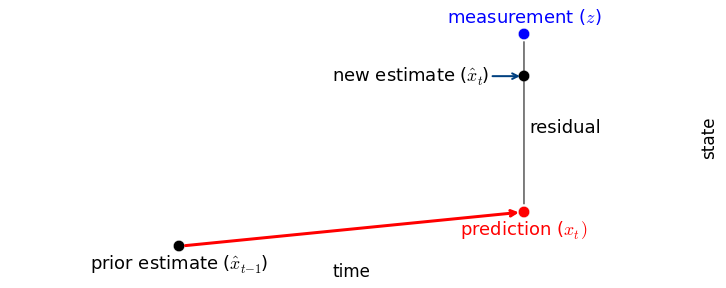

In [13]:
from mkf_internal import show_residual_chart
show_residual_chart()

To confirm this, let's plot the residual for the filter during the maneuver. I will reduce the amount of noise in the data to make it easier to see the residual.

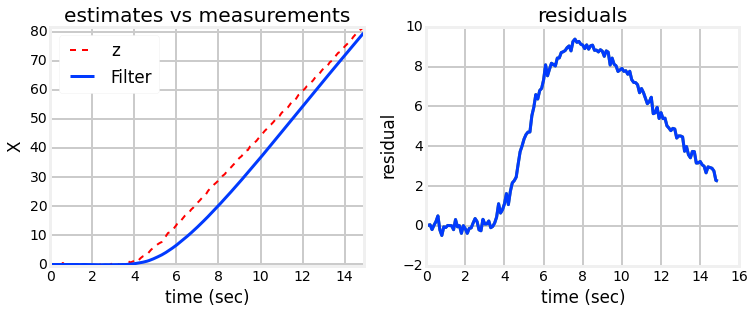

In [14]:
from adaptive_internal import plot_track_and_residuals

def show_residual_chart():
    dt = 0.1
    # initialize filter
    cvfilter= make_cv_filter(dt)
    initialize_filter(cvfilter)
    pos2, zs2 = generate_data(120, noise_factor=0.2)
    xs2 = pos2[:, 0]
    z_xs2 = zs2[:, 0]

    cvfilter.Q = Q_discrete_white_noise(dim=2, dt=dt, var=0.02)
    xs = []
    res = []
    for z in z_xs2:
        cvfilter.predict()
        cvfilter.update([z])
        xs.append(cvfilter.x[0])
        res.append(cvfilter.y[0])
        
    xs = np.asarray(xs)
    plot_track_and_residuals(t, xs, z_xs2, res)
   
show_residual_chart()

On the left I have plotted the noisy measurements (not the track!) against the Kalman filter output. On the right I display the residuals computed by the filter - the difference between the measurement and the predictions made by the Kalman filter. Let me emphasize this to make this clear. The plot on the right is not merely the difference between the two lines in the left plot. The left plot shows the difference between the measurements and the final Kalman filter output, whereas the right plot shows us the difference between the plot and the *predictions of the process model*. 

That may seem like a subtle distinction, but from the plots you see it is not. The amount of deviation in the left plot when the maneuver starts is small, but the deviation in the right tells a very different story. If the tracked object was moving according to the process model the residual plot should bounce around 0.0. This is because the measurements will be obeying the equation 

$$measurement = process\_model(t) + noise(t)$$.

Once the target starts maneuvering the predictions of the target behavior will not match the behavior as the equation will be 

$$measurement = process\_model(t) + maneuver\_delta(t) + noise(t)$$.

Therefore if the residuals diverge from a mean of 0.0 we know that a maneuver has commenced.

We can see from the residual plot that we have our work cut out for us. We can clearly see the result of the maneuver in the residual plot, but the amount of noise in the signal obscures the start of the maneuver. This is our age old problem of extracting the signal from the noise. 

## Adjustable Process Noise

The first approach we will consider will use a lower order model and adjust the process noise based on whether a maneuver is occurring or not. When the residual gets *large* (for some reasonable definition of large) we will increase the process noise. This will cause the filter to favor the measurement over the process prediction and the filter will track the signal closely. When the residual is small we will then scale back the process noise.

There are many ways of doing this in the literature, I will consider a couple of choices.

### Continuous Adjustment

The first method (from Bar-Shalom [1]) normalizes the square of the residual using the following equation:

$$ \epsilon = \mathbf{y^\mathsf{T}S}^{-1}\mathbf{y}$$

where $\mathbf{y}$ is the residual and $\mathbf{S}$ is the measurement covariance, which has the equation

$$\mathbf{S} = \mathbf{HPH^\mathsf{T}} + \mathbf{R}$$

If the linear algebra used to compute this confuses you, recall that we can think of matrix inverses as division, so $\epsilon = \mathbf{y^\mathsf{T}S}^{-1}\mathbf{y}$ can be thought of as computing

$$\epsilon=\frac{\mathbf{y}^2}{\mathbf{S}}$$

Both $\mathbf{y}$ and $\mathbf{S}$ are attributes of `filterpy.KalmanFilter` so implementation is of this computation will be straightforward.

Let's look at a plot of $\epsilon$ against time.

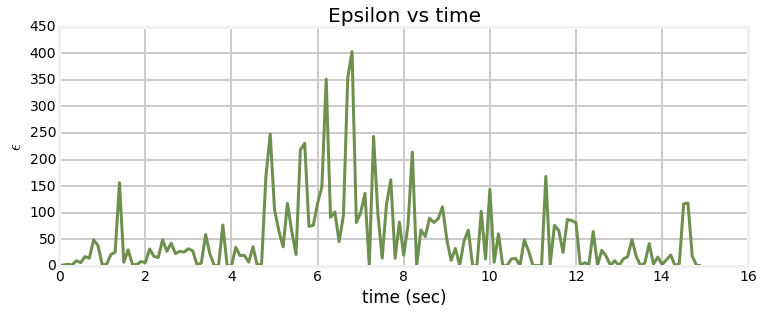

In [15]:
from filterpy.common import dot3
from numpy.linalg import inv

# reinitialize filter
initialize_filter(cvfilter)

cvfilter.R = np.eye(1)*0.2
cvfilter.Q = Q_discrete_white_noise(dim=2, dt=dt, var=0.02)
epss = []
for z in z_xs2:
    cvfilter.predict()
    cvfilter.update([z])
    y = cvfilter.y
    S = cvfilter.S
    eps = dot3(y.T, inv(cvfilter.S), y)
    epss.append(eps)

plt.plot(t, epss)
bp.set_labels(title='Epsilon vs time', x='time (sec)', y='$\epsilon$')

This plot should make clear the effect of normalizing the residual. Squaring the residual ensures that the signal is always greater than zero, and normalizing by the measurement covariance scales the signal so that we can distinguish when the residual is markedly changed relative to the measurement noise. The maneuver starts at t=3 seconds, and we can see that $\epsilon$ starts to increase rapidly not long after that. 

We will want to start scaling $\mathbf{Q}$ up once $\epsilon$ exceeds some limit, and back down once it again falls below that limit. We multiply $\mathbf{Q}$ by a scaling factor. Perhaps there is literature on choosing this factor analytically; I derive it experimentally. We can be somewhat more analytical about choosing the limit for $\epsilon$ (named $\epsilon_{max}$) - generally speaking once the residual is greater than 3 standard deviations or so we can assume the difference is due to a real change and not to noise. However, sensors are rarely truly Gaussian and so a larger number, such as 5-6 standard deviations is used in practice.

I have implemented this algorithm using reasonable values for $\epsilon_{max}$ and the $\mathbf{Q}$ scaling factor. To make inspection of the result easier I have limited the plot to the first 10 seconds of simulation. 

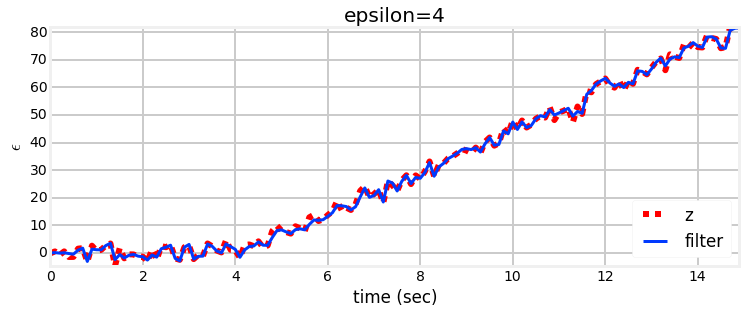

In [16]:
from filterpy.common import dot3
from numpy.linalg import inv

# reinitialize filter
initialize_filter(cvfilter)
cvfilter.R = np.eye(1)*0.2

cvfilter.Q = Q_discrete_white_noise(dim=2, dt=dt, var=0.02)

Q_scale_factor = 1000.
eps_max = 4.

epss = []
xs = []
count = 0
for i, z in zip(t, z_xs2):
    cvfilter.predict()
    cvfilter.update([z])
    y = cvfilter.y
    S = cvfilter.S
    eps = dot3(y.T, inv(cvfilter.S), y)
    epss.append(eps)
    xs.append(cvfilter.x[0])

    if eps > eps_max:
        cvfilter.Q *= Q_scale_factor
        count += 1
    elif count > 0:
        cvfilter.Q /= Q_scale_factor
        count -= 1
        
bp.plot_measurements(t, z_xs2, lw=6, label='z')
bp.plot_filter(t, xs, label='filter')
plt.legend(loc=4)
bp.set_labels(title='epsilon=4', x='time (sec)', y='$\epsilon$')

The performance of this filter is markedly better than the constant velocity filter. The constant velocity filter took roughly 10 seconds to reacquire the signal after the start of the maneuver. The adaptive filter takes under a second to do the same. 

### Continuous Adjustment - Standard Deviation Version

Another, very similar method from Zarchan [2] sets the limit based on the standard deviation of the measurement error covariance. Here the equations are:

$$ \begin{aligned}
std &= \sqrt{\mathbf{HPH}^\mathsf{T} + \mathbf{R}} \\
&= \sqrt{\mathbf{S}}
\end{aligned}
$$

If the absolute value of the residual is more than some multiple of the standard deviation computed above we increase the process noise by a fixed amount, recompute Q, and continue.

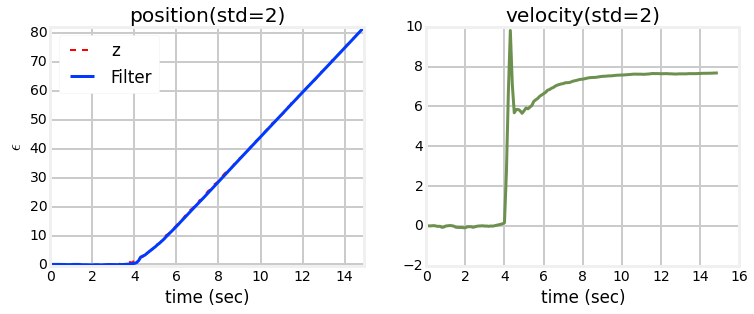

In [17]:
from filterpy.common import dot3
from numpy.linalg import inv
from math import sqrt

def zarchan_adaptive_filter(Q_scale_factor, std_scale, 
                            std_title=False,
                            Q_title=False):
    pos2, zs2 = generate_data(120, noise_factor=0.2)
    xs2 = pos2[:,0]
    z_xs2 = zs2[:,0]

    # reinitialize filter
    initialize_filter(cvfilter)

    cvfilter.R = np.eye(1)*0.2

    phi = 0.02
    cvfilter.Q = Q_discrete_white_noise(dim=2, dt=dt, var=phi)
    xs = []
    ys = []
    count = 0
    for i,z in zip(t,z_xs2):
        cvfilter.predict()
        cvfilter.update([z])
        y = cvfilter.y
        S = cvfilter.S
        std = sqrt(S)

        xs.append(cvfilter.x)
        ys.append(y)

        if abs(y[0]) > std_scale*std:
            phi += Q_scale_factor
            cvfilter.Q = Q_discrete_white_noise(dim=2, dt=dt, var=phi)
            count += 1
        elif count > 0:
            phi -= Q_scale_factor
            cvfilter.Q = Q_discrete_white_noise(dim=2, dt=dt, var=phi)
            count -= 1

    xs = np.asarray(xs)
    plt.subplot(121)
    bp.plot_measurements(t, z_xs2, label='z')
    bp.plot_filter(t, xs[:, 0])
    bp.set_labels(x='time (sec)', y='$\epsilon$')
    plt.legend(loc=2)
    if std_title:
        plt.title('position(std={})'.format(std_scale))
    elif Q_title:
        plt.title('position(Q scale={})'.format(Q_scale_factor))
    else:
        plt.title('position')
        
    plt.subplot(122)
    plt.plot(t, xs[:, 1])
    plt.xlabel('time (sec)')
    if std_title:
        plt.title('velocity(std={})'.format(std_scale))
    elif Q_title:
        plt.title('velocity(Q scale={})'.format(Q_scale_factor))
    else:
        plt.title('velocity')        
    plt.show()
    
zarchan_adaptive_filter(1000, 2, std_title=True)

So I chose to use 1000 as the scaling factor for the noise, and 2 as the standard deviation limit. Why these numbers? Well, first, let's look at the difference between 2 and 3 standard deviations. 

**Two Standard Deviations**

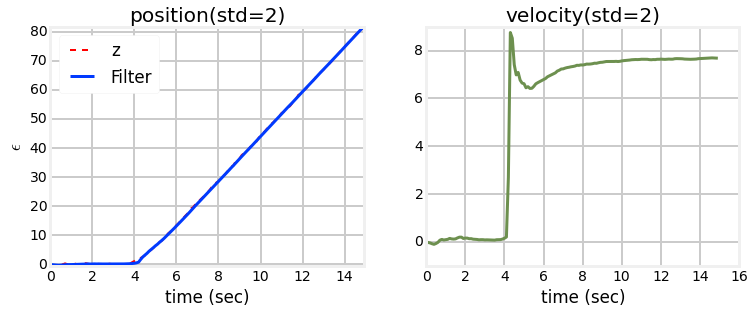

In [18]:
zarchan_adaptive_filter(1000, 2, std_title=True)

**Three Standard Deviations**

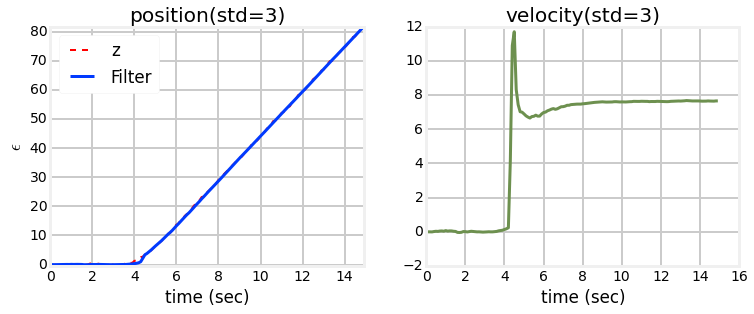

In [19]:
zarchan_adaptive_filter(1000, 3, std_title=True)

We can see from the charts that the filter output for the position is very similar regardless of weather we use 2 standard deviations or three. But the computation of the velocity is a different matter. Let's explore this further. First, lets make the standard deviation very small.

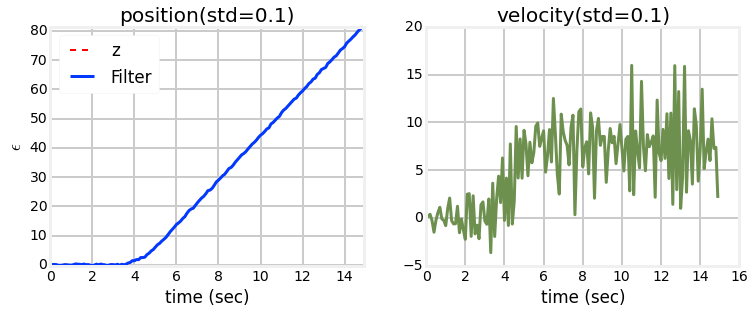

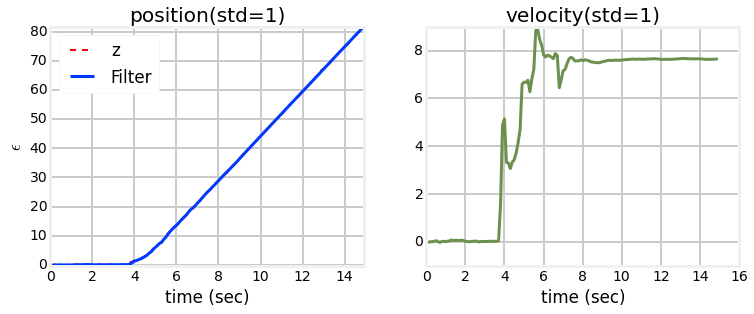

In [20]:
zarchan_adaptive_filter(1000, .1, std_title=True)
zarchan_adaptive_filter(1000, 1, std_title=True)

As the standard deviation limit gets smaller the computation of the velocity gets worse. Think about why this is so. If we start varying the filter so that it prefers the measurement over the prediction as soon as the residual deviates even slightly from the prediction we very quickly be giving almost all the weight towards the measurement. With no weight for the prediction we have no information from which to create the hidden variables. So, when the limit is 0.1 std you can see that the velocity is swamped by the noise in the measurement. On the other hand, because we are favoring the measurements so much the position follows the maneuver almost perfectly.

Now let's look at the effect of various increments for the process noise. Here I have held the standard deviation limit to 2 std, and varied the increment from 1 to 10,000.

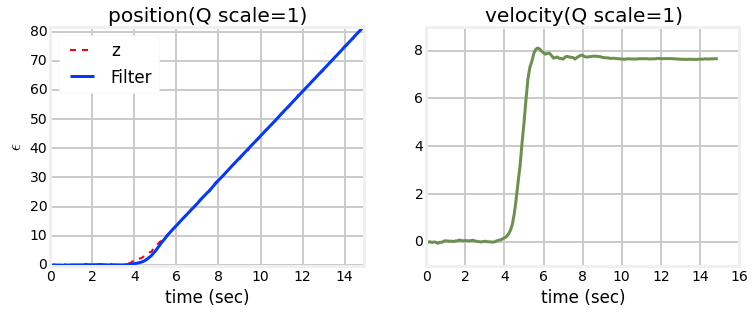

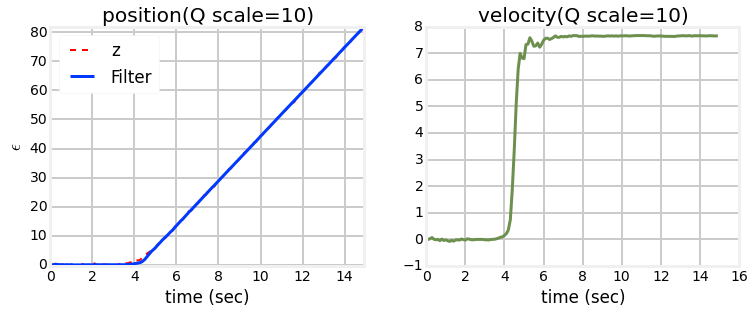

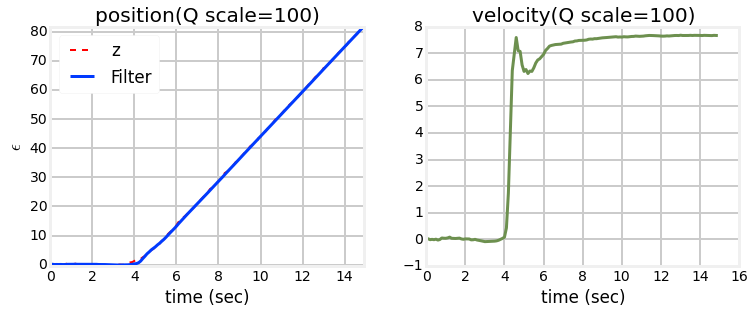

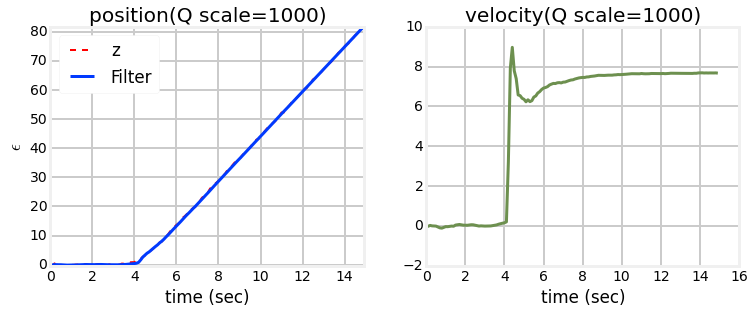

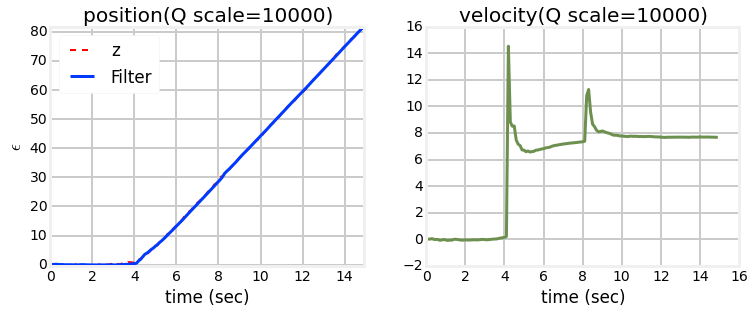

In [21]:
zarchan_adaptive_filter(1, 2, Q_title=True)
zarchan_adaptive_filter(10, 2, Q_title=True)
zarchan_adaptive_filter(100, 2, Q_title=True)
zarchan_adaptive_filter(1000, 2, Q_title=True)
zarchan_adaptive_filter(10000, 2, Q_title=True)

Here we can see that the position estimate gets marginally better as the increment factor increases, but that the velocity estimate starts to create a large overshoot. 

It isn't possible for me to tell you which of these is 'correct'. You will need to test your filter's performance against real and simulated data, and choose the design that best matches the performance you need for each of the state variables.

## Fading Memory Filter

Fading memory filters are not normally classified as an adaptive filter since they do not adapt to the the input, but they do provide good performance with maneuvering targets. They also have the benefit of having a very simple computational form for first, second, and third order kinematic filters (e.g. the filters we are using in this chapter). This simple form does not require the Ricatti equations to compute the gain of the Kalman filter, which drastically reduces the amount of computation. However, there is also a form that works with the standard Kalman filter. I will focus on the latter in this chapter since our focus is more on adaptive filters. Both forms of the fading memory filter are implemented in `FilterPy`.

The Kalman filter is recursive, but it incorporates all of the previous measurements into the current computation of the filter gain. If the target behavior is consistent with the process model than this allows the Kalman filter to find the optimal estimate for every measurement. Consider a ball in flight - we can clearly estimate the position of the ball at time t better if we take into account all the previous measurement. If we only used some of the measurements we would be less certain about the current position, and thus more influenced by the noise in the measurement. If this is still not clear, consider the worst case. Suppose we forget all but the last measurement and estimates. We would then have no confidence in the position and trajectory of the ball, and would have little choice but to weight the current measurement heavily. If the measurement is noisy, the estimate is noisy. We see this effect every time a Kalman filter is initialized. The early estimates are noisy, but then they settle down as more measurements are acquired.

However, if the target is maneuvering it is not always behaving like the process model predicts. In this case remembering all of the past measurements and estimates is a liability. We can see this in all of the charts above. The target initiates a turn, and the Kalman filter continues to project movement in a straight line. This is because the filter has built a history of the target's movement, and incorrectly 'feels' confident that the target is moving in a straight line at a given heading and velocity. 

The fading memory filter accounts for this problem by giving less weight to older measurements, and greater weight to the more recent measurements. 

There are many formulations for the fading memory filter; I use the one provided by Dan Simon in *Optimal State Estimation* [3]. I will not go through his derivation, but only provide the results.

The Kalman filter equation for the covariances of the estimation error is

$$ \mathbf{P} = \mathbf{FPF}^\mathsf{T} + \mathbf{Q}$$

We can force the filter to forget past measurements by multiplying a term $\alpha$

$$ \tilde{\mathbf{P}} = \alpha^2\mathsf{FPF}^\mathtt{T} + \mathbf{Q}$$

where $\alpha > 1.0$. If $\alpha == 1$ then we get the normal Kalman filter performance. $\alpha$ is an attribute of `FilterPy`s Kalman filter class; its value defaults to 1 so the filter acts like a Kalman filter unless $\alpha$ is assigned a value other than 1. There is no hard and fast rule for choosing $\alpha$, but it is typically very close to 1, such as 1.01. You will need to make many runs with either simulated or real data to determine a value that responds to maneuvers without causing the estimate to become too noisy due to overly weighting the noisy measurement.

Why does this work? If we increase the estimate error covariance the filter becomes more uncertain about it's estimate, hence it gives more weight to the measurement. 

One caveat - if we use $\alpha$ than we are computing $\tilde{\mathbf{P}}$, not $\mathbf{P}$. In other words, `KalmanFilter.P` *is not* equal to the covariance of the estimation error, so do not treat it as if it is.

Let's filter our data using the fading memory filter and see the result. I will inject a lot of error into the system so that we can compare various approaches.

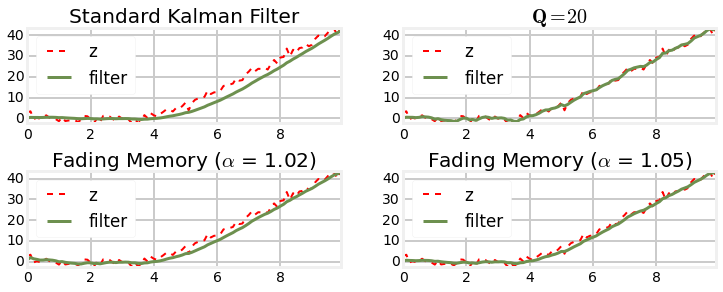

In [22]:
# reinitialize filter

pos2, zs2 = generate_data(70, noise_factor=1.2)
xs2 = pos2[:, 0]
z_xs2 = zs2[:, 0]

cvfilter.x = array([0., 0.])
cvfilter.Q = Q_discrete_white_noise(dim=2, dt=dt, var=0.02)
cvfilter.alpha = 1.00

xs = []
res = []
for z in z_xs2:
    cvfilter.predict()
    cvfilter.update([z])
    xs.append(cvfilter.x[0])
    res.append(cvfilter.y[0])
xs = np.asarray(xs)
plt.subplot(221)
bp.plot_measurements(t[0:100], z_xs2, label='z')
plt.plot(t[0:100], xs, label='filter')
plt.legend(loc=2)
plt.title('Standard Kalman Filter')

cvfilter.x = array([0., 0.])
cvfilter.Q = Q_discrete_white_noise(dim=2, dt=dt, var=20.)
cvfilter.alpha = 1.00

xs = []
res = []
for z in z_xs2:
    cvfilter.predict()
    cvfilter.update([z])
    xs.append(cvfilter.x[0])
    res.append(cvfilter.y[0])
    
xs = np.asarray(xs)

plt.subplot(222)
bp.plot_measurements(t[0:100], z_xs2, label='z')
plt.plot(t[0:100], xs, label='filter')
plt.legend(loc=2)
plt.title('$\\mathbf{Q}=20$')

cvfilter.x = array([0., 0.])
cvfilter.Q = Q_discrete_white_noise(dim=2, dt=dt, var=0.02)
cvfilter.alpha = 1.02

xs = []
res = []
for z in z_xs2:
    cvfilter.predict()
    cvfilter.update([z])
    xs.append(cvfilter.x[0])
    res.append(cvfilter.y[0])
xs = np.asarray(xs)
plt.subplot(223)
bp.plot_measurements(t[0:100], z_xs2, label='z')
plt.plot(t[0:100], xs, label='filter')
plt.legend(loc=2)
plt.title('Fading Memory ($\\alpha$ = 1.02)')

cvfilter.x = array([0., 0.])
cvfilter.Q = Q_discrete_white_noise(dim=2, dt=dt, var=0.02)
cvfilter.alpha = 1.05

xs = []
res = []
for z in z_xs2:
    cvfilter.predict()
    cvfilter.update([z])
    xs.append(cvfilter.x[0])
    res.append(cvfilter.y[0])
xs = np.asarray(xs)
plt.subplot(224)
bp.plot_measurements(t[0:100], z_xs2, label='z')
plt.plot(t[0:100], xs, label='filter')
plt.legend(loc=2)
plt.title('Fading Memory ($\\alpha$ = 1.05)');

The first plot shows the performance of the Kalman filter. The filter diverges when the maneuver starts and does not reacquire the signal until about 10 seconds. I then made the filter track the maneuver very quickly by making the process noise large, but this has the cost of making the filter estimate very noisy due to unduly weighting the noisy measurements. I then implemented a fading memory filter with $\alpha=1.02$. The filtered estimate is very smooth, but it does take a few seconds to converge when the target regains steady state behavior. However, the time to do so is considerably smaller than for the Kalman filter, and the amount of lag is much smaller - the estimate for the fading memory is much closer to the actual track than the Kalman filter's track is. Finally, I bumped up $\alpha$ to 1.05. Here we can see that the filter responds almost instantly to the maneuver, but that the estimate is not as straight during the steady state operation because the filter is forgetting the past measurements. 

This is quite good performance for such a small change in code! Note that there is no 'correct' choice here. You will need to design your filter based on your needs and the characteristics of the measurement noise, process noise, and maneuvering behavior of the target.

## Noise Level Switching

To be written

## Variable State Dimension

To be written - vary state order based on whether a maneuver is happening.

## Multiple Model Estimation

The example I have been using in this chapter entails a target moving in a steady state, performing a maneuver, and then returning to a steady state. We have been thinking of this as two models - a constant velocity model, and a constant acceleration model. Whenever you can describe the system as obeying one of a finite set of models you can use *Multiple Model (MM) Estimation*. This means what it sounds like. We use a bank of multiple filters, each using a different process to describe the system, and either switch between them or blend them based on the dynamics of the tracked object. 

As you might imagine this is a broad topic, and there are many ways of designing and implementing MM estimators. But consider a simple approach for the target we have been tracking in this chapter. One idea would be to simultaneously run a constant velocity and a constant acceleration filter, and to switch between their outputs when we detect a maneuver by inspecting the residuals. Even this choice gives us many options. Consider the dynamics of a turning object. For example, an automobile turns on a wheelbase - the front wheels turn, and the car pivots around the rear wheels. This is a nonlinear process, so for best results we would want to use some type of nonlinear filter (EKF, UKF, etc) to model the turns. On the other hand, a linear constant velocity filter would perform fine for the steady state portions of the travel. So our bank of filters might consist of a linear KF and an EKF filter for the turns. However, neither is particularly well suited for modeling behaviors such as accelerating and braking. So a highly performing MM estimator might contain a bank of many filters, each designed to perform best for a certain performance envelope of the tracked object.

Of course, you do not need to base your filters on the order of the model. You can use different noise models, different adapters in each. For example, in the section above I showed many plots depicting the effects of changing parameters on the estimate of the velocity and position. Perhaps one setting works better for position, and a different setting for velocity. Put both in your bank of filters. You could then take the best estimates for the position from one filter, and the best estimate for the velocity from a different filter.

### A Two Filter Adaptive Filter

I trust the idea of switching between filters to get the best performance is clear, but what mathematical foundations should we use to implement it? The problem that we face is trying to detect via noisy measurements when a change in regime should result in a change in model. What aspect of the Kalman filter measures how far the measurement deviates from the prediction? Yes, the *residual*.

Let's say we have a two state (constant velocity) Kalman filter. As long as the target is not maneuvering the filter will track it's behavior closely, and roughly 68% of the measurements should fall within 1$\sigma$. Furthermore the residual should fluctuate around 0 because as many if the sensor is Gaussian an equal number of measurement should have positive error as have negative errors. If the residual grows and stays beyond predicted bounds then the target must not be performing as predicted by the state model. We saw this earlier in this chart where the residual switched from bouncing around 0 to suddenly jumping and staying above zero once the tracked object began maneuvering.

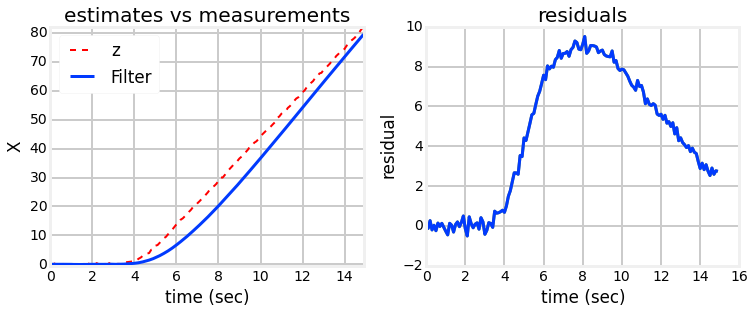

In [23]:
show_residual_chart()

For this problem we saw that the constant velocity filter performed better the constant acceleration filter while the object was in steady state, and the opposite was true when the object is maneuvering. In the chart above that transition occurs at 4 seconds. 

So the algorithm is easy. Initialize both a  constant velocity and constant acceleration filter and run them together in a predict/update loop. After every update examine the residual of the  constant velocity filter. If it falls within theoretical bounds use the estimate from the constant velocity filter as the estimate, otherwise use the estimate from the constant acceleration filter. If you have enough insight into your problem, you can also choose to blend the outputs of the two filters proportional to the size of the residual.

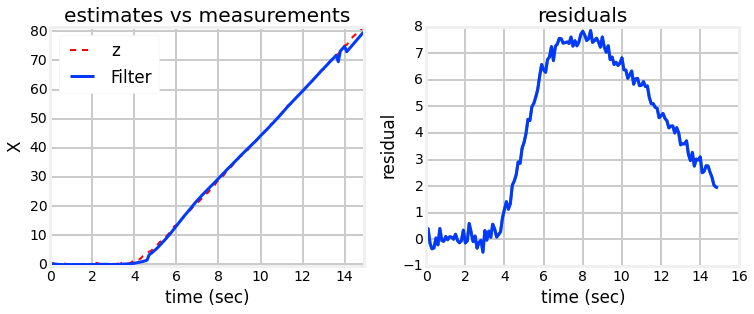

In [24]:
def run_filter_bank(threshold):
    dt = 0.1
    cvfilter= make_cv_filter(dt)
    cafilter = make_ca_filter(dt)

    pos, zs = generate_data(120, noise_factor=0.2)
    z_xs = zs[:, 0]
    t = np.arange(0, len(z_xs) * dt, dt)
    xs, res = [], []

    for z in z_xs:
        cvfilter.predict()
        cafilter.predict()
        cvfilter.update([z])
        cafilter.update([z])
        
        std = np.sqrt(cvfilter.R[0,0])
        if abs(cvfilter.y[0]) < 2 * std:
            xs.append(cvfilter.x[0])
        else:
            xs.append(cafilter.x[0])
        res.append(cvfilter.y[0])
    xs = np.asarray(xs)
    plot_track_and_residuals(t, xs, z_xs, res)

run_filter_bank(threshold=1.4)

Here we get nearly ideal performance. While the target is not maneuvering our estimate is nearly noise free, and then once it does maneuver we quickly detect that and switch to the constant acceleration filter. 

## References

* [1] Bar-Shalom, Yaakov, Xiao-Rong Li, and Thiagalingam Kirubarajan. *Estimation with Applications to Tracking and Navigation*. New York: Wiley, p. 424, 2001. 

* [2] Zarchan, Paul, and Howard Musoff. *Fundamentals of Kalman Filtering: A Practical Approach*. Reston, VA: American Institute of Aeronautics and Astronautics, 2000. Print.

* [3] Simon, Dan. Optimal State Estimation: Kalman, H and Nonlinear Approaches. Hoboken, NJ: Wiley-Interscience, p. 208-212, 2006